In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import sklearn
import nltk
from gensim.models import Word2Vec

%matplotlib inline

In [4]:
empath = pd.read_pickle('drive/My Drive/empath')

empath.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",5,2013-10-11,[[Grocery & Gourmet Food]],NaN,0.0,0.0
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",5,2012-12-06,[[Grocery & Gourmet Food]],NaN,0.0,NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,0.0,NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN,0.0,0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN,0.0,NaN


In [5]:
empath = empath.drop(labels=['unixReviewTime', 'categories', 'brand', 'overall'], axis=1)

empath.head()

,reviewerID,asin,reviewText,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN


In [11]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

stop_words = set(stopwords.words('english')) 

stemmer = PorterStemmer()

def process_text(sentence):
    token_words = nltk.word_tokenize(sentence)
    no_stopwords = [word.lower() for word in token_words if word not in stop_words and not \
                    all(c in string.punctuation for c in word) and not len(word) < 2]
    return [stemmer.stem(word) for word in no_stopwords]

print(process_text('I ordered spongbob slippers and I got John'))

['order', 'spongbob', 'slipper', 'got', 'john']


In [12]:
empath['tokenReviews'] = empath['reviewText'].apply(lambda x : process_text(x))

empath.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ..."
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,..."


In [0]:
empath.to_pickle('empath_token')

In [15]:
size=100

model = Word2Vec(empath['tokenReviews'].values, min_count=1, size=size)

print(model)

Word2Vec(vocab=511855, size=100, alpha=0.025)


In [16]:
model.save('model.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [17]:
def token_to_vectors(x):
    arr = []
    for word in x:
        if word in model.wv.vocab:
            arr.append(model.wv[word])
    if (len(arr) == 0):
        return np.zeros((size,))
    return np.array(arr).mean(axis=0)

print(token_to_vectors(['gmo', 'undisputed']))

[-0.04402099 -3.8415065  -5.467218   -1.3234435   1.9598614  -1.332723
  2.0610793  -1.1682926  -2.2003584   2.4413273   0.20715532  3.3212528
 -1.2224286   2.638012    0.7927386   2.580944   -0.3779589  -2.593872
 -0.54438     0.43381268  2.6893     -1.9064891  -3.310894    0.507299
  0.8520623  -0.25355816 -4.934345   -1.1224589   1.1241015  -0.8427675
  0.92275983  1.6497685  -3.6747909  -5.64894    -0.6884977  -0.13964067
 -2.049497    1.058169   -1.0222832   0.29756078  1.5104594  -2.6639192
 -2.5842166  -3.722186    1.9064506  -1.0038728  -2.3591323   3.1446831
  1.8132597  -4.6179056  -0.63248193  1.8198811   2.5830512   1.3222747
  2.758876    2.8688314   1.0363625   1.0974296  -0.9990008  -2.7074764
 -0.6733885  -0.6523644   1.749059   -0.33799282 -0.08485289  0.9892475
 -3.85351     2.852966   -2.5171382  -2.5297549  -1.3684621   0.39454022
  4.573968    0.87234485 -0.72909164  2.8941681  -0.16098817  0.28779116
  2.7012954   1.0207574   1.5668892  -2.2837398  -2.2626593  -1.

In [18]:
empath['feature'] = empath['tokenReviews'].apply(lambda x : token_to_vectors(x))

empath.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053..."
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."


In [19]:
train = empath[~empath['danger'].isna()]

train.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456..."
6,A3LZA698SQPCXE,1453060464,My wife picked some of this up on sale. I usu...,0.0,0.0,"[my, wife, pick, sale, usual, drink, crystal, ...","[1.3866923, 0.019513289, -0.98902005, -0.86818..."
19,A2IPE2KFGTZMI3,3295000018,"Fast and hot, did I mention hot, well it's hot",0.0,0.0,"[fast, hot, mention, hot, well, 's, hot]","[0.07104542, -1.3793547, 1.2464379, -0.8240789..."
23,A2H05FXY2BXUAN,3295000018,High quality! worth every penny you pay for it...,0.0,0.0,"[high, qualiti, worth, everi, penni, pay, the,...","[0.19685604, -0.27718312, -0.36387432, 0.29339..."


In [0]:
from sklearn.model_selection import train_test_split

stratify_parameter = train.danger

X = np.array(train['feature'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, train['danger'].astype(int).values, \
                                                    test_size=0.1, random_state=10, \
                                                   stratify=stratify_parameter)

In [21]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100, random_state=10)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [22]:
from sklearn.metrics import accuracy_score

y_pred = classifier.predict(X_test)

print("Accuracy on validation set : {0:.3f}".format(accuracy_score(y_test, y_pred)))

Accuracy on validation set : 0.911


In [23]:
test = empath[empath['danger'].isna()]

test.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."
5,A3DTB6RVENLQ9Q,1453060375,Don't buy this item - rip off at this price. ...,0.0,NaN,"[do, n't, buy, item, rip, price, my, bad, mist...","[0.6653651, 0.7529061, 0.08680784, -0.06787298..."
7,A2XZPK86YY9R6G,1453060782,I bought these on sale (2 for $4) at my local ...,0.0,NaN,"[bought, sale, local, supermarket, probabl, ov...","[0.732765, 0.1461897, -0.9984229, 0.028604036,..."


In [0]:
X_testing_set = np.array(test['feature'].tolist())

test_pred = classifier.predict(X_testing_set)

In [27]:
test['danger'] = test_pred

test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,0,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,0,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."
5,A3DTB6RVENLQ9Q,1453060375,Don't buy this item - rip off at this price. ...,0.0,0,"[do, n't, buy, item, rip, price, my, bad, mist...","[0.6653651, 0.7529061, 0.08680784, -0.06787298..."
7,A2XZPK86YY9R6G,1453060782,I bought these on sale (2 for $4) at my local ...,0.0,0,"[bought, sale, local, supermarket, probabl, ov...","[0.732765, 0.1461897, -0.9984229, 0.028604036,..."


In [31]:
final = pd.merge(empath, test, how='left', on=['reviewerID', 'asin'])

final.head()

,reviewerID,asin,reviewText_x,healthScore_x,danger_x,tokenReviews_x,feature_x,reviewText_y,healthScore_y,danger_y,tokenReviews_y,feature_y
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053...",NaN,NaN,NaN,NaN,NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649...","This is my absolute, undisputed favorite tea r...",0.0,0.0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801...",I ordered spongbob slippers and I got John Cen...,0.0,0.0,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456...",NaN,NaN,NaN,NaN,NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094...",This product by Archer Farms is the best drink...,0.0,0.0,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."


In [32]:
final = final.drop(['reviewText_y', 'healthScore_y', 'tokenReviews_y', 'feature_y'], axis=1)

final.head()

,reviewerID,asin,reviewText_x,healthScore_x,danger_x,tokenReviews_x,feature_x,danger_y
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053...",NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649...",0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801...",0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456...",NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094...",0.0


In [34]:
final = final.rename(columns={'reviewText_x': 'reviewText', 'healthScore_x': 'healthScore', 'danger_x': 'danger', 'tokenReviews_x': 'tokenReviews', 'feature_x': 'feature'})

final.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature,danger_y
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053...",NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649...",0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801...",0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456...",NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094...",0.0


In [35]:
final['danger'] = np.where(final['danger'].isna(), final['danger_y'], final['danger'])

final.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature,danger_y
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053...",NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,0.0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649...",0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,0.0,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801...",0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456...",NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,0.0,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094...",0.0


In [36]:
final = final.drop('danger_y', axis=1)

final.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053..."
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,0.0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,0.0,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,0.0,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."


In [43]:
print("Does column 'danger' still contains nan values ? > {}".format(final['danger'].isna().any()))

Does column 'danger' still contains nan values ? > False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1d5275048>]],
      dtype=object)

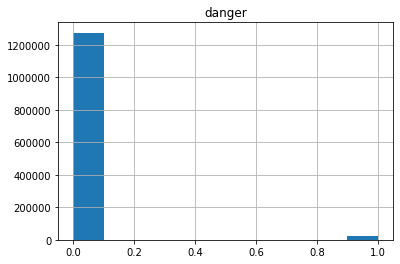

In [42]:
final['danger'] = final['danger'].astype(np.int8)
final.hist(column='danger')

In [48]:
threats = len(final[final['danger'] == 1])

print("Number of reviews presenting health threats : {}".format(threats))
print("Number of reviews : {}".format(len(final)))
print("Percentage : {0:.3f}%".format(threats*100/len(final)))

Number of reviews presenting health threats : 21337
Number of reviews : 1297156
Percentage : 1.645%
